#FIXME:
* location of supp data hird.shp and the workflow image
* replace/ update flow chart
* fix image paths
* update flowchart for notebook
* add paper to prerequisites, and link to FC and WOs notebooks

# Introduction to the DEA Wetlands Insight Tool <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_wo_3),
[ga_ls_fc_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_fc_3),

> **Note:** [ga_ls9c_ard_3](https://explorer.dea.ga.gov.au/products/ga_ls9c_ard_3) can be included once derivative Water Observations and Fractional Cover products have been generated

This notebook demonstrates the method for reproducing results from the Wetlands Insight Tool.

## Background

Wetlands provide a wide range of ecosystem services including improving water quality, carbon sequestration, as well as providing habitat for fish, amphibians, reptiles and birds.  Managing wetlands in Australia is challenging due to competing pressures for water availability and highly variable climatic settings.  The DEA Wetlands Insight Tool has been developed to provide catchment managers, environmental water holders, and wetlands scientists a consistent historical baseline of wetlands dynamics from 1987 onwards. 

The DEA Wetlands Insight Tool summarises how the amount of water, green vegetation, dry vegetation and bare soil varies over time within each wetland. It provides the user with the ability to compare how the wetland is behaving now with how it has behaved in the past.  This allows users to identify how changes in water availability have affected the wetland. It achieves this by presenting a combined view of Water Observations from Space, Tasseled Cap Wetness and Fractional Cover measurements from the Landsat series of satellites, summarised as a stacked line plot to show how that wetland has changed over time. 

## Applications
The product is designed to support wetland managers, catchment managers and environmental waterholders in understanding whether or not wetlands are changing over time.  In instances where the wetlands are changing, the tool allows users to identify whether the changes are gradual, rapid, once-off or cyclical in nature.  For example the response of wetlands to the following drivers can be assessed:

* Changes in river flow volumes
* Changes in flood frequency
* Long term shifts in rainfall
* Wet-season/Dry-season shifts in water availability
* Invasive weeds
* Environmental watering events

Care should be used when interpreting Wetlands Insight Tool results as increases/decreases in particular cover types can be associated with different processes.  For example an increase in green cover could indicate canopy recovery of desirable wetland species or an increase in the amount of invasive weeds.

## Publications
* Dunn, B., Ai, E., Alger, M.J., Fanson, B., Fickas, K.C., Krause, C.E., Lymburner, L., Nanson, R., Papas, P., Ronan, M., Thomas, R.F., 2023. Wetlands Insight Tool: Characterising the Surface Water and Vegetation Cover Dynamics of Individual Wetlands Using Multidecadal Landsat Satellite Data. Wetlands 43, 37. Available: https://doi.org/10.1007/s13157-023-01682-7
* Dunn, B., Lymburner, L., Newey, V., Hicks, A. and Carey, H., 2019. Developing a Tool for Wetland Characterization Using Fractional Cover, Tasseled Cap Wetness And Water Observations From Space. IGARSS 2019 - 2019 IEEE International Geoscience and Remote Sensing Symposium, 2019, pp. 6095-6097. Available: https://doi.org/10.1109/IGARSS.2019.8897806.

## Related products
DEA Fractional Cover (Landsat, DEPRECATED)
DEA Wetness Percentiles (Landsat)
DEA Water Observations (Landsat, DEPRECATED)

## WIT calculation

For each pixel, we calculate its WIT values based on the Flowchart from [Dunn, et al., 2023](https://doi.org/10.1007/s13157-023-01682-7).

<p align="center">
  <img width="460" height="300" src="./Fig2.png">
</p>



## Getting Started

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
import datetime
import geopandas as gpd
import itertools
import numpy as np
import pandas as pd
import xarray as xr

import datacube
import dea_tools.bandindices
import dea_tools.datahandling
from dea_tools.spatial import xr_rasterize

import sys

sys.path.insert(1, "../Tools/dea_tools/")
import wetlands

### Connect to the datacube:

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="WITbook")

### Analysis parameters

A section to inform the user of any parameters they'll need to configure to run the notebook:

* `poly`: The polygon of your wetland of interest. This can be a shapefile or a GeoJSON. User will need to drag and drop the file into the sandbox and update the file path. Your polygon should be in EPSG:3577 [GDA94 Australian Albers](https://epsg.io/3577).

* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


## Load a shapefile that describes your wetlands study area

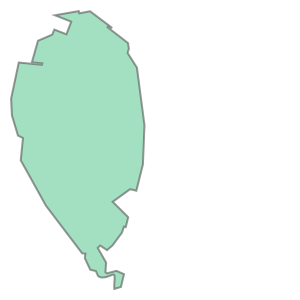

In [3]:
# This cell loads and plots the wetlands polygon. If no output, check your polygon
poly = gpd.read_file("../Supplementary_data/DEA_Wetlands_Insight_Tool/hird.shp")
poly.geometry[0]

In [4]:
# Specifying coordinate reference system of the polygon.
gpgon = datacube.utils.geometry.Geometry(poly.geometry[0], crs=poly.crs)

In [5]:
# Select time period. Consistent data is available from 01-09-1987.
time = ("2014-11-01", "2015-01-01")
# time = ('1985-01-01', '2015-01-01')

## Load Landsat, Water Observations, and Fractional Cover:

### Load and Mask Landsat data

Load Landsat 5, 7 and 8 data. Not including Landsat 7 SLC off period (31-05-2003 to 06-04-2022). If the following cell successfully loads data, it will generate output text, similar to:


```
Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Loading 8 time steps
```

For further information on the functions used here, go to the [function documentation](https://github.com/GeoscienceAustralia/dea-notebooks/blob/b13f020f8a41c30bc1bb4120ce492098a25a2bfa/Tools/dea_tools/datahandling.py).

In [6]:
# Define which spectral bands are being used in the analysis
bands = [
    f"nbart_{band}" for band in ("blue", "green", "red", "nir", "swir_1", "swir_2")
]

# Load Landsat 5, 7 and 8 data. Not including Landsat 7 SLC off period (31-05-2003 to 06-04-2022).
ds = dea_tools.datahandling.load_ard(
    dc,
    products=["ga_ls8c_ard_3", "ga_ls7e_ard_3", "ga_ls5t_ard_3"],
    ls7_slc_off=False,
    measurements=bands,
    geopolygon=gpgon,
    output_crs="EPSG:3577",
    resolution=(-30, 30),
    resampling={"fmask": "nearest", "*": "bilinear"},
    time=time,
    group_by="solar_day",
)

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Loading 8 time steps


### Load Water Observations and Fractional Cover datasets

Load Fractional Cover and Water Observations data into the same spatial grid and resolution as the loaded Landsat dataset.

In [7]:
ds_wo = dc.load("ga_ls_wo_3", resampling="nearest", group_by="solar_day", like=ds)
ds_fc = dc.load("ga_ls_fc_3", resampling="nearest", group_by="solar_day", like=ds)

### Locate and remove any observations which aren't in all three datasets

In [8]:
missing = set()
for t1, t2 in itertools.product(
    [ds_fc.time.values, ds_wo.time.values, ds.time.values], repeat=2
):
    missing_ = set(t1) - set(t2)
    missing |= missing_

ds_fc = ds_fc.sel(time=[t for t in ds_fc.time.values if t not in missing])
ds = ds.sel(time=[t for t in ds.time.values if t not in missing])
ds_wo = ds_wo.sel(time=[t for t in ds_wo.time.values if t not in missing])

## Calculate Tasseled Cap Wetness from the Landsat data


We use Tasseled Cap Wetness (TCW) to identify areas in wetlands that are wet, but not identified by the WOfS algorithm as open water. 

The coefficients of Crist ([1985](https://doi.org/10.1016/0034-4257(85)90102-6)) were used to calculate TCW. 

TCW has values between −12,915 and 7032 when applied to DEA Landsat data. As TCW increases, the pixel becomes 
wetter ([Dunn, et al., 2023](https://doi.org/10.1007/s13157-023-01682-7)).


In [9]:
tcw = dea_tools.bandindices.calculate_indices(
    ds, index="TCW", collection="ga_ls_3", normalise=False, drop=True, inplace=False
)

Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


### Normalise Fractional Cover

Divide the FC values by 100 to keep them in $[0, 1]$ (ignoring for now that values can exceed 100 due to how FC is calculated):

In [10]:
bs = ds_fc.bs / 100
pv = ds_fc.pv / 100
npv = ds_fc.npv / 100

### Generate the WIT raster bands:

Create an empty dataset called `output_rast` and populate with values from input datasets.

In [11]:
rast_names = ["pv", "npv", "bs", "wet", "water"]
output_rast = {n: xr.zeros_like(bs) for n in rast_names}

output_rast["bs"].values[:] = bs
output_rast["pv"].values[:] = pv
output_rast["npv"].values[:] = npv

### Masking 

1. Mask pixels not in the polygon

2. Use the [Water Observations bit flags](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/DEA_products/DEA_Water_Observations.ipynb) to mask noncontiguous data, low solar incidence angle, cloud, and water out of the `wet` category. We distinguish `open water` from `wet` as mutually exclusive categories. 

### Thresholding

We threshold TCW at −350, with values above this threshold used to characterise ‘wet’ pixels ([Dunn, et al., 2023](https://doi.org/10.1007/s13157-023-01682-7)).

In [12]:
# rasterise the shapefile where poly is the vector data and pv is the xarray template
poly_raster = xr_rasterize(poly, pv) > 0

# mask includes noncontiguous data, low solar incidence angle, cloud, and water
mask = (ds_wo.water & 0b01100011) == 0
mask &= poly_raster

# set open water to water present and classified as water as per Water Observations and bit flags
open_water = ds_wo.water & (1 << 7) > 0

# set wet pixels where not masked and above threshold of -350
wet = tcw.where(mask).TCW > -350

In [13]:
# adding wet and water values to output raster

# TCW
output_rast["wet"].values[:] = wet.values.astype(float)
for name in rast_names[:3]:
    output_rast[name].values[wet.values] = 0

# WO
output_rast["water"].values[:] = open_water.values.astype(float)
for name in rast_names[:4]:
    output_rast[name].values[open_water.values] = 0

In [14]:
# Masking again
ds_wit = xr.Dataset(output_rast).where(mask)

Mask entire observations where the polygon is more than 10% masked:

In [15]:
# Calculate percentage missing
pc_missing = (~mask).where(poly_raster).mean(dim=["x", "y"])

ds_wit = ds_wit.where(pc_missing < 0.1)

The WIT results are now computed. All that's left is to normalise them.

## Normalise WIT result

Users are provided the option to normalise the WIT result. Normalisation only affects vegetation Fractional Cover values. We rescale Fractional Cover values by the area of the vegetation so that the total percentage adds to 1. This makes the graph more interpretable and is done as the Fractional Cover algorithm sometimes returns values which add to greater than 1.

We suggest normalisation when displaying the WIT plots but perhaps not if calculating population statistics. 

In [16]:
# covert ds_wit: XArray.Dataset to polygon_base_df: pandas.DataFrame

polygon_base_df = pd.DataFrame()
polygon_base_df["date"] = ds_wit.time.values

for band in rast_names:
    polygon_base_df[band] = ds_wit[band].mean(dim=["x", "y"])

In [17]:
polygon_base_df = wetlands.normalise_wit(polygon_base_df)

## Create WIT Plot

Edit the polygon name in the cell below, if required. A png file will be created in this directory with the same name as the polygon, unless the `png_name` variable below is edited. 

In [18]:
polygon_name = "Hird Swamp"
png_name = polygon_name  # file will be png_name.png

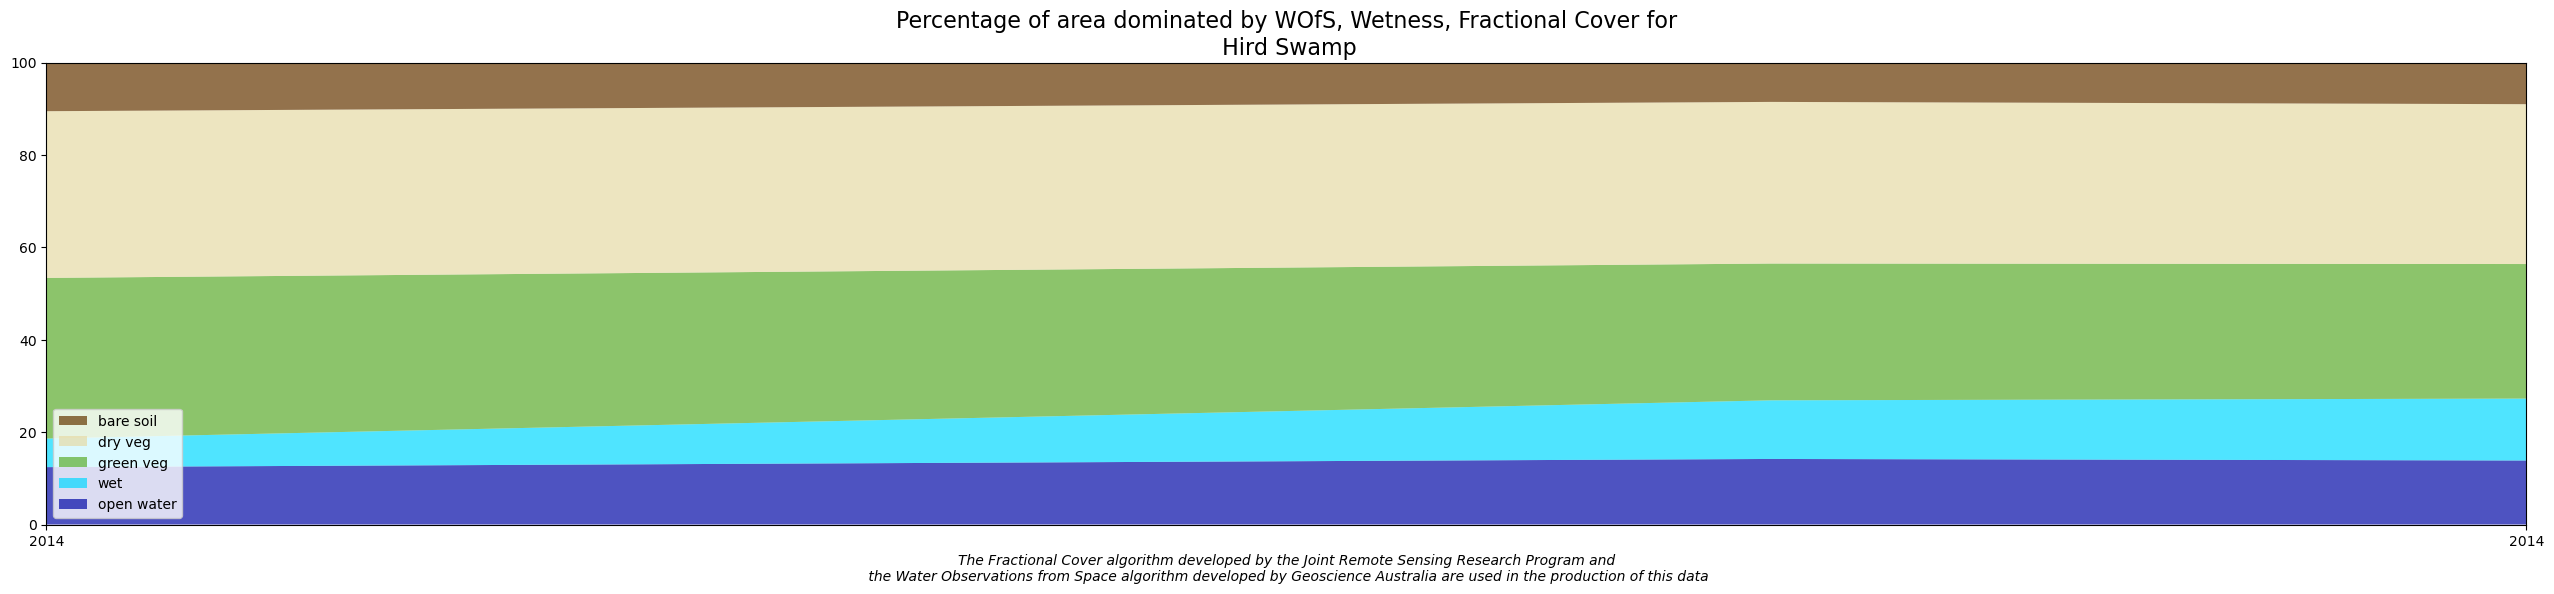

In [19]:
wetlands.display_wit_stack_with_df(polygon_base_df, polygon_name, png_name)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2023 

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)